In [1]:
import numpy as np
import pickle
import sys
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
redDim=10

In [3]:
np.set_printoptions(threshold=sys.maxsize)

In [4]:
# load snapshot
# Choose either Re=10000 or Re=100
Re=10000

if Re==10000:
    file_name_snapshot="./data/snapshot_full_high_Re.p"
    nx=60
    ny=60
    nt=1500
    
    POD_basis=redDim
    file_name_POD="./model/POD_high_Re_red-dim_{}.p".format(redDim)
elif Re==100:
    file_name_snapshot="./data/snapshot_full_low_Re.p"
    nx=60
    ny=60
    nt=1500
    
    POD_basis=redDim
    file_name_POD="./model/POD_low_Re_red-dim_{}.p".format(redDim)
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
snapshot = pickle.load(open(file_name_snapshot,'rb'))
snapshot_u_orig = snapshot['u']
snapshot_v_orig = snapshot['v']

# substract IC
ndata = snapshot_u_orig.shape[0]
nset = round(ndata/(nt+1))

snapshot_u = np.array([])
snapshot_v = np.array([])
for foo in range(nset):
    snapshot_u = np.append(snapshot_u,snapshot_u_orig[foo*(nt+1)+1:(foo+1)*(nt+1)]-snapshot_u_orig[foo*(nt+1)])
    snapshot_v = np.append(snapshot_v,snapshot_v_orig[foo*(nt+1)+1:(foo+1)*(nt+1)]-snapshot_v_orig[foo*(nt+1)])
    
snapshot_u = np.reshape(snapshot_u,(-1,ny*nx))
snapshot_v = np.reshape(snapshot_v,(-1,ny*nx))

# remove BC
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

snapshot_u = snapshot_u[:,free_raveled_indicies]
snapshot_v = snapshot_v[:,free_raveled_indicies]

print(snapshot_u.shape)
print(snapshot_v.shape)

(6000, 3364)
(6000, 3364)


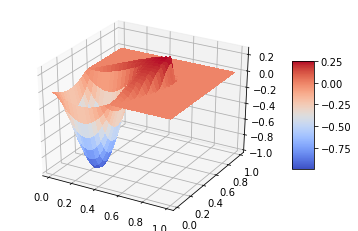

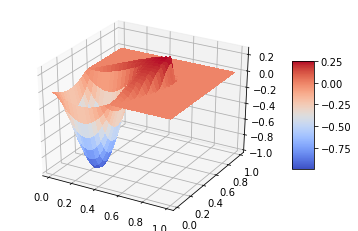

In [5]:
# generate mesh grid
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

# plot data centered on IC
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), snapshot_u[-1].reshape(ny-2,nx-2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), snapshot_v[-1].reshape(ny-2,nx-2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

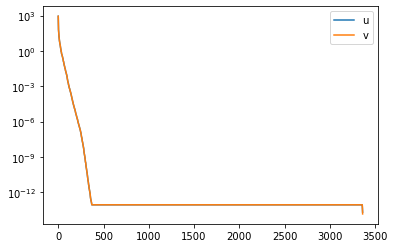

In [6]:
# do svd decomposition
U_u,S_u,V_uT=np.linalg.svd(snapshot_u.T,full_matrices=False)
U_v,S_v,V_vT=np.linalg.svd(snapshot_v.T,full_matrices=False)

plt.figure()
plt.semilogy(S_u)
plt.semilogy(S_v)
plt.legend(('u','v'))
plt.show()

In [7]:
acc_u=np.sum(S_u[:POD_basis]**2)/np.sum(S_u**2)*100
acc_v=np.sum(S_v[:POD_basis]**2)/np.sum(S_v**2)*100
print(acc_u)
print(acc_v)

phi_u=U_u[:,:POD_basis]
phi_v=U_v[:,:POD_basis]
print(phi_u.shape)
print(phi_v.shape)

99.92227225224364
99.92227225224364
(3364, 10)
(3364, 10)


In [8]:
print(np.sum(S_u[:POD_basis])/np.sum(S_u)*100)
print(np.sum(S_v[:POD_basis])/np.sum(S_v)*100)

92.80290397563213
92.80290397563213


In [9]:
# save LS-ROM
POD={'u':phi_u,'v':phi_v}
pickle.dump(POD,open(file_name_POD,'wb'))